In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import learning_curve, validation_curve, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

In [8]:
def train(model, X_train, X_test, y_train, y_test):
    """Treina um modelo de regressão e avalia seu desempenho."""
    print("Training Model:", model.__class__.__name__)
    model.fit(X_train, y_train)
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    train_mae = mean_absolute_error(y_train, y_pred_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    train_r2 = r2_score(y_train, y_pred_train)
    train_rmsle = np.sqrt(mean_squared_error(np.log1p(y_train), np.log1p(y_pred_train)))
    
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    test_r2 = r2_score(y_test, y_pred_test)
    test_rmsle = np.sqrt(mean_squared_error(np.log1p(y_test), np.log1p(y_pred_test)))
    
    print(f"Train - MAE: {train_mae:.4f}, RMSE: {train_rmse:.4f}, R²: {train_r2:.4f}, RMSLE: {train_rmsle:.4f}")
    print(f"Test - MAE: {test_mae:.4f}, RMSE: {test_rmse:.4f}, R²: {test_r2:.4f}, RMSLE: {test_rmsle:.4f}")
    
    plt.figure(figsize=(12, 5))
    plt.scatter(y_test, y_pred_test, alpha=0.5, color='blue')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
    plt.xlabel("Actual Energy Consumption")
    plt.ylabel("Predicted Energy Consumption")
    plt.title("Actual vs. Predicted Energy Consumption")
    plt.grid()
    plt.show()

def hyper_parameter(hypertuned_model, hyperparameters, X_train, y_train, n_iter=20):
    """Busca os melhores hiperparâmetros para um modelo de regressão."""
    print("Hyperparameter Tuning using RandomizedSearchCV for:", hypertuned_model.__class__.__name__)
    model = RandomizedSearchCV(hypertuned_model, hyperparameters, scoring="neg_mean_absolute_error", n_iter=n_iter, random_state=42, verbose=1)
    model.fit(X_train, y_train)
    print("Best Parameters:", model.best_params_)
    return model.best_params_

def k_fold_cross_validation(model, k, X_train, y_train):
    """Validação cruzada K-Fold para regressão."""
    print("K-Fold Cross Validation for:", model.__class__.__name__)
    kfold = KFold(n_splits=k, shuffle=True)
    scores = cross_val_score(model, X_train, y_train, scoring="r2", cv=k)
    
    plt.plot(range(1, k + 1), scores, 'o-', label="R² Score")
    plt.title("Cross Validation Scores")
    plt.xlabel("Fold")
    plt.ylabel("R² Score")
    plt.xticks(range(1, k + 1))  
    plt.xlim(1, k)             
    plt.legend()
    plt.grid()
    plt.show()
    
    print(f"Average R² score: {np.mean(scores):.4f}")

In [9]:

df = pd.read_csv('../data/energy_data_cleaned.csv')
print("Dataset shape:", df.shape)

Dataset shape: (1957301, 16)


In [10]:
y = df['target']
X = df.drop(columns=['target'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Training Model: RandomForestRegressor
Train - MAE: 0.0248, RMSE: 0.0578, R²: 0.9990, RMSLE: 0.0245
Test - MAE: 0.0669, RMSE: 0.1570, R²: 0.9930, RMSLE: 0.0589


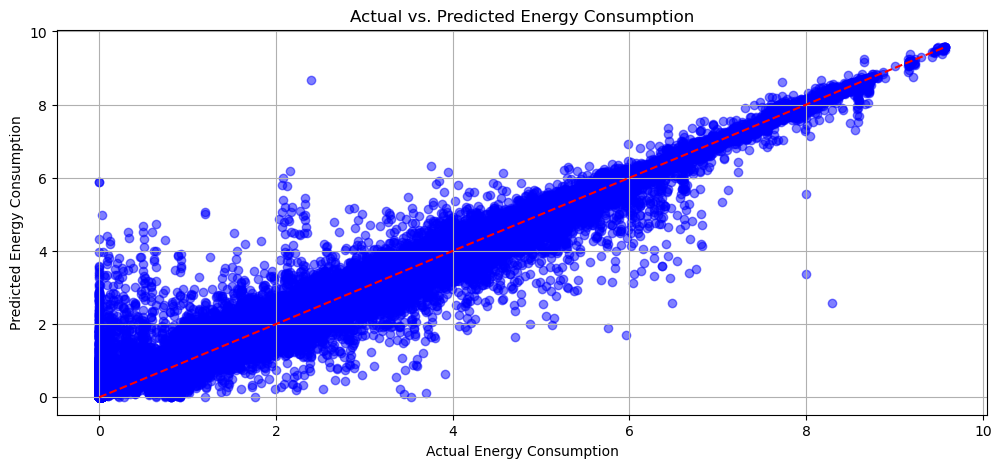

In [11]:
base_model = RandomForestRegressor(random_state=42)
train(base_model, X_train, X_test, y_train, y_test)

In [12]:
hyperparameters = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Ajuste de hiperparâmetros
best_params = hyper_parameter(base_model, hyperparameters, X_train, y_train, n_iter=15)

# Criar modelo com melhores parâmetros
model = RandomForestRegressor(**best_params, random_state=42)

Hyperparameter Tuning using RandomizedSearchCV for: RandomForestRegressor
Fitting 5 folds for each of 15 candidates, totalling 75 fits


/opt/anaconda3/envs/bolsa/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
15 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/bolsa/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/bolsa/lib/python3.10/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/envs/bolsa/lib/python3.10/site-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  F

Best Parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None}


K-Fold Cross Validation for: RandomForestRegressor


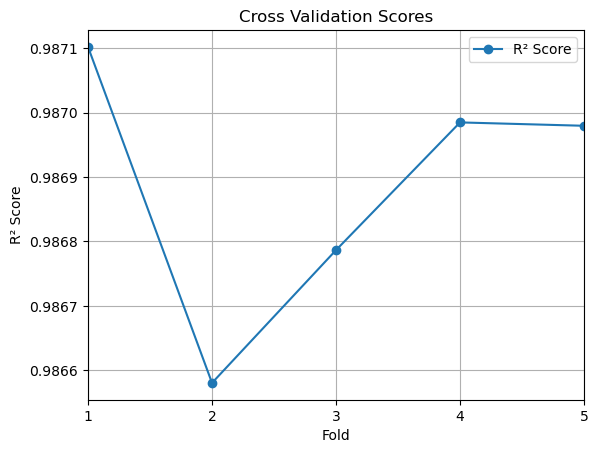

Average R² score: 0.9869
Training Model: RandomForestRegressor
Train - MAE: 0.0709, RMSE: 0.1377, R²: 0.9946, RMSLE: 0.0577
Test - MAE: 0.1036, RMSE: 0.2024, R²: 0.9883, RMSLE: 0.0794


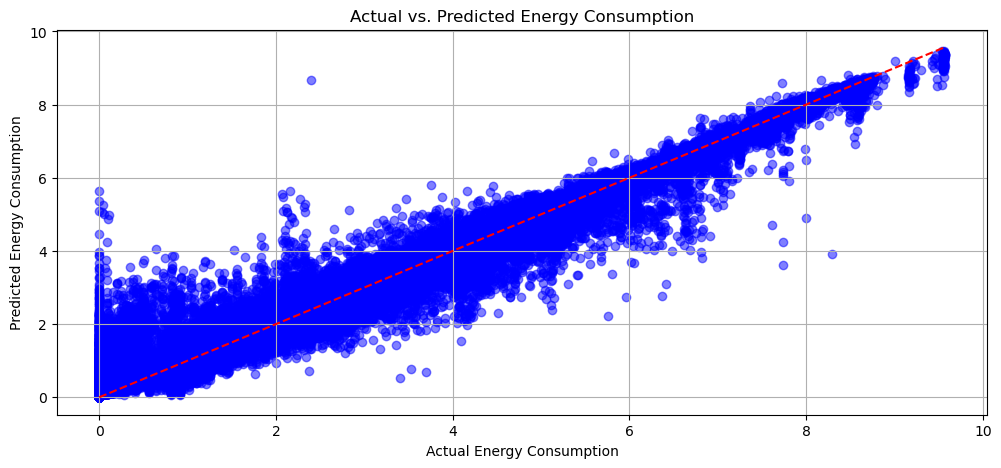

Feature Importance:
              Feature  Importance
3         square_feet    0.274900
5         floor_count    0.189486
14       m2_per_floor    0.132991
0         building_id    0.112368
1             site_id    0.061866
4          year_built    0.058280
13              month    0.051041
9   precip_depth_1_hr    0.022919
10               hour    0.022777
2         primary_use    0.021150


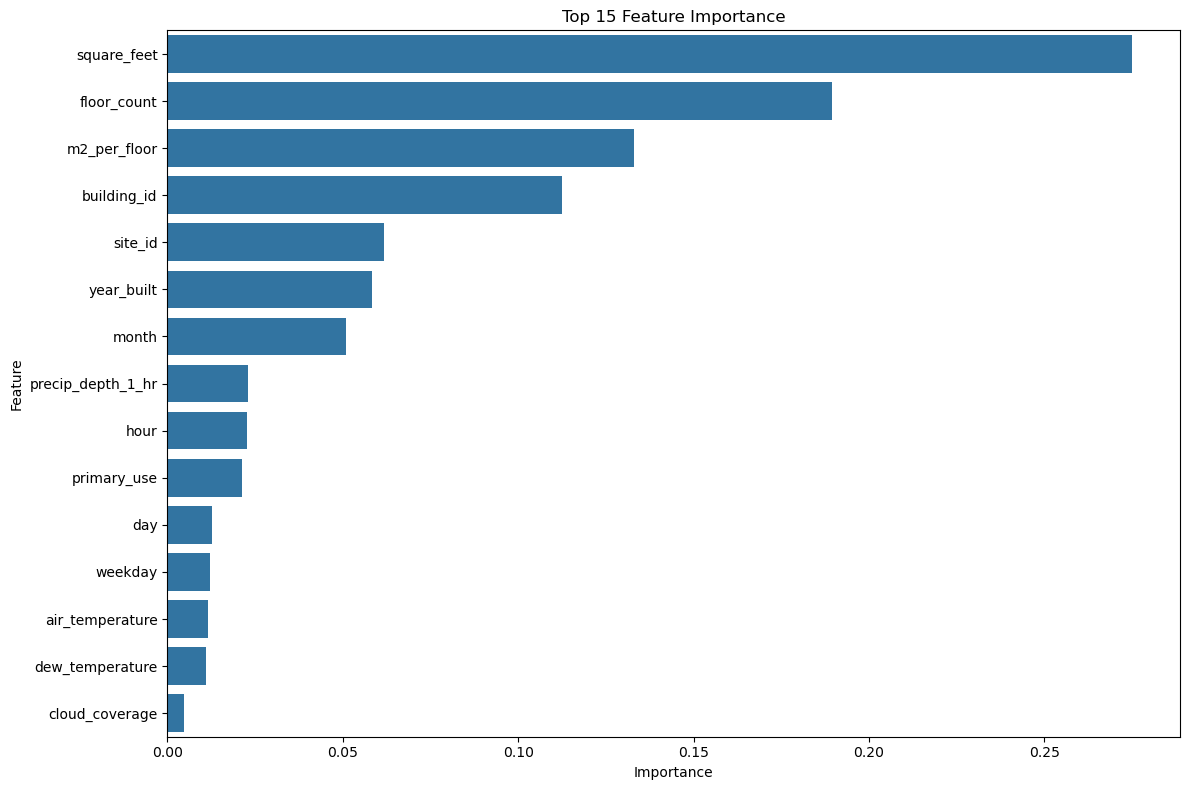

In [13]:
k_fold_cross_validation(model, k=5, X_train=X_train, y_train=y_train)

# Treinar modelo final
train(model, X_train, X_test, y_train, y_test)

# Importância das features
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Feature Importance:")
print(feature_importance.head(10))

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
plt.title('Top 15 Feature Importance')
plt.tight_layout()
plt.show()
